In [ ]:
# !pip3 install -U -q ipywidgets
# !pip3 install -U -q pyarrow
# !jupyter nbextension enable --py widgetsnbextension

In [2]:
# Standard Data Science Helpers
import numpy as np
import pandas as pd
import scipy
import random 

from sklearn.datasets import make_classification, make_blobs
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)


from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import roc_auc_score

import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(colorscale='plotly', world_readable=True)

# Extra options
pd.options.display.max_rows = 30
pd.options.display.max_columns = 25

# Show all code cells outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import os
from IPython.display import Image, display, HTML
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from sklearn.base import clone
 
from IPython.core.debugger import set_trace

In [4]:
#Some utility functions.

class DataContainer():
    def __init__(self):
        pass
    
    def set_x(self, X):
        self.X = X
    
    def set_y(self, y):
        self.y = y
        

    
        
        
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
def classification_assessment(X_test, y_test, y_test_predicted, clf, data_container=None):
    print(classification_report(y_test, y_test_predicted))
    cnf_matrix = confusion_matrix(y_test, y_test_predicted, labels=[1,0])
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['incident=1','no incident=0'],normalize= False, 
                          title='Confusion matrix')
    ns_probs = [0 for _ in range(len(y_test))]

    # plot ROC
    if data_container is None:
        plt.figure()
    lr_probs = clf.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
#     print(lr_probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, ns_thresh = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, lr_thresh = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    if data_container is None:
        plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
        plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
        # axis labels
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        # show the legend
        plt.legend()
        # show the plot
        plt.show()
    else: 
        roc_ax = data_container.roc_ax
        roc_ax.plot(lr_fpr, lr_tpr, marker='.', label='Logistic, auc:{:0.2f}'.format(lr_auc))
        roc_ax.legend()
    return lr_probs
    
    
def dilute_class(X, y, class_tag, dilute_factor):
    y_indices = y==class_tag
    num_class_entries = sum(y_indices)
    diluted_ys_indices =  random.sample(range(num_class_entries), int(num_class_entries*dilute_factor))
    diluted_ys = y[y_indices][diluted_ys_indices]
    diluted_X_other_classes = X[~y_indices]
    diluted_X_class = X[y_indices][diluted_ys_indices]
    diluted_X = np.concatenate([diluted_X_other_classes, diluted_X_class])
    diluted_y = np.concatenate([ y[~y_indices], diluted_ys])
    
    return diluted_X, diluted_y

<h2>Single feature, two normal distributions</h2>

In [10]:
#Choosing the initial dataset.
#See https://plotly.com/python/histograms/

%matplotlib qt

data_container = DataContainer()
from ipywidgets import interact, widgets


@interact_manual
def choose_dataset( num_samples=[500000, 10000, 1000000], 
                    ones_distribution=['normal', 'gev'],
                    center_one=widgets.FloatSlider(min=-2,max=-0.5,step=0.1,value=-1),
                    center_zero=widgets.FloatSlider(min=0.5,max=2,step=0.1,value=1),
                    std_one=widgets.FloatSlider(min=0.2,max=2,step=0.1,value=0.8),
                    std_zero=widgets.FloatSlider(min=0.2,max=2,step=0.1,value=0.5)
                  ):
    display(HTML(f'<h2>Plotting dataset of size {num_samples} <h2>'))
    dataset_artificial_balanced_1_feature = \
                            make_blobs(n_samples=num_samples, n_features=1, centers=[[center_zero], [center_one]],
                                cluster_std=[std_zero, std_one],  shuffle=False, random_state=4) 
    X, y = dataset_artificial_balanced_1_feature
    if ones_distribution == 'gev':
#         X_ones = np.random.exponential(10, sum(y))
        X_ones = genextreme.rvs(c=1/300, loc=center_one, scale=std_one, size=sum(y))
# u = np.random.rand(100000)
# lmbd=1
# k=1.5
# weibull = lmbd*np.power((-np.log(1-u)),1/k) 
        
        print(X_ones.shape)
        print(X.shape)
        X[y==1] = np.array([X_ones]).T
        
   
    data_container.set_x(X)
    data_container.set_y(y)
#     print("X shape: {}".format(X.shape))
#     print("y shape: {}".format(y.shape))
    X_ones = X[y==1].T[0]
    X_zeros = X[y==0].T[0]
    print("1: mean: {:0.3f}, std: {:0.3f} \n0: mean: {:0.3f}, std: {:0.3f} ".format(X_ones.mean(), X_ones.std(), X_zeros.mean(), X_zeros.std()))
 
    fig = go.Figure()
    
    fig.add_trace(go.Histogram(x=X_zeros, nbinsx=500, histnorm='probability density', opacity=0.7, name='zeros'))
    fig.add_trace(go.Histogram(x=X_ones, nbinsx=500, histnorm='probability density', opacity=0.7, name='ones'))
    fig.show()


      


interactive(children=(Dropdown(description='num_samples', options=(500000, 10000, 1000000), value=500000), Dro…

<h2>Single feature, three normal distributions</h2>

In [ ]:
#Split ones dataset

@interact_manual
def choose_dataset_split( zero_nsamples=[500000, 10000, 1000000], 
                          one_1_nsamples=[500000, 10000, 1000000], 
                          one_2_nsamples=[500000, 20000, 50000],
                    center_zero=widgets.FloatSlider(min=-1,max=1,step=0.1,value=0),
                    center_one_1=widgets.FloatSlider(min=1,max=3,step=0.1,value=2),
                    center_one_2=widgets.FloatSlider(min=-4,max=-2,step=0.1,value=-3),
                    std_zero=widgets.FloatSlider(min=0.2,max=2,step=0.1,value=0.8),
                    std_one_1=widgets.FloatSlider(min=0.2,max=2,step=0.1,value=0.6),
                    std_one_2=widgets.FloatSlider(min=0.2,max=2,step=0.1,value=0.4)
                  ):
    display(HTML(f'<h2>Plotting dataset of size {num_samples} <h2>'))

    dataset_split =  make_blobs(n_samples=[zero_nsamples, one_1_nsamples, one_2_nsamples ],
                                n_features=1, centers=[[center_zero], [center_one_1],[center_one_2]],
                                    cluster_std=[std_zero, std_one_1, std_one_2],  shuffle=False, random_state=4)

#     dataset_artificial_balanced_1_feature = \
#                             make_blobs(n_samples=num_samples, n_features=1, centers=[[center_zero], [center_one]],
#                                 cluster_std=[std_zero, std_one],  shuffle=False, random_state=4) 
    X, y = dataset_split
    y[y==2] = 1
    X = np.concatenate([X, X*X], axis=1)
    data_container.set_x(X)
    data_container.set_y(y)
    X_ones = X[y==1].T[0]
    X_zeros = X[y==0].T[0]
    print("1: mean: {:0.3f}, std: {:0.3f} \n0: mean: {:0.3f}, std: {:0.3f} ".format(X_ones.mean(), X_ones.std(), X_zeros.mean(), X_zeros.std()))
 
    fig = go.Figure()
    
    fig.add_trace(go.Histogram(x=X_zeros, nbinsx=500, histnorm='probability density', opacity=0.7, name='zeros'))
    fig.add_trace(go.Histogram(x=X_ones, nbinsx=500, histnorm='probability density', opacity=0.7, name='ones'))
    fig.show()


<h2>Single feature, GEV</h2>

In [21]:
data_container = DataContainer()
mu = -2
sigma = 2
k = 1.5
x = np.arange(mu+0.05, mu+10*sigma, 0.05);
F = 1-np.exp(-np.power((-(mu-x)/sigma), k));
num_repetitions = 10000
xx = np.array([x]*num_repetitions);
xx = xx.reshape(1, num_repetitions*len(x))[0];

u1 = np.random.rand(len(xx));#
# u2 = np.random.rand(len(x))
F_inverse_u = xx - sigma*np.power((-np.log(1-u1)), 1/k);#

print(F_inverse_u.shape);
# F_inverse_u
x_ones = xx[F_inverse_u >= 0];
x_zeros = xx[F_inverse_u < 0];
n1, bins1,_ = plt.hist(x_ones, bins=np.append(x, x[-1] + 0.05), color='r', label= "ones", alpha=0.5, density=False);
n0, bins0,_ = plt.hist(x_zeros, bins=np.append(x, x[-1] + 0.05), color='b', label= "zeros", alpha=0.5, density=False);
empirical_probs = list(map(lambda tup : tup[0]/(tup[0]+tup[1]), zip(n1,n0) ))

F_0 = 1-np.exp(-np.power((-(-x)/sigma), k));
plt.plot(x, F_0, color='y');
plt.plot(x, empirical_probs, color='g');
F_sig = 1/(1+np.exp(-x/(0.5*sigma)))
plt.plot(x, F_sig, color='k');
plt.legend();
# plt.plot(x, F)


# n1, bins1,_ = plt.hist(x_ones, bins=np.append(x, x[-1] + 0.05), color='r', label= "ones", alpha=0.5, density=True);


def generate_x_y_gev(n0, n1, bins):
    X = np.array([])
    y = np.array([]);
    binsize = bins[-1]-bins[-2];
    for tupp in zip(n0, n1, bins ):
#         print(tupp)
        x_zeros = tupp[2] + binsize*np.random.rand(int(tupp[0]));
        x_ones = tupp[2] + binsize*np.random.rand(int(tupp[1]));
        X = np.concatenate([X, x_zeros, x_ones]);
        y = np.concatenate([y, np.zeros(len(x_zeros)), np.ones(len(x_ones)) ]);
#         set_trace()
    return X,y

X,y = generate_x_y_gev(n0, n1, bins1);
plt.figure()
X_ones = X[y==1]
X_zeros = X[y==0]
plt.hist(X_ones, bins=bins1, color = 'r', alpha = 0.4)
plt.hist(X_zeros, bins=bins1, color = 'b', alpha = 0.4)
plt.show();

data_container.set_x(X.reshape(len(X), 1))
data_container.set_y(y)

print("X shape: {}".format(data_container.X.shape))
print("y shape: {}".format(data_container.y.shape))
# print(y)

(3990000,)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning:

invalid value encountered in power



<Figure size 1280x960 with 0 Axes>

(array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           36.,   132.,   236.,   320.,   434.,   565.,   706.,   864.,
         1007.,  1207.,  1340.,  1458.,  1697.,  1834.,  2017.,  2248.,
         2353.,  2612.,  2848.,  3016.,  3142.,  3346.,  3550.,  3724.,
         3922.,  3987.,  4241.,  4468.,  4609.,  4809.,  4965.,  5054.,
         5220.,  5474.,  5593.,  5657.,  5901.,  6129.,  6157.,  6320.,
         6460.,  6563.,  6682.,  6823.,  6974.,  7132.,  7253.,  7231.,
         7358.,  7520.,  7559.,  7750.,  7846.,  7871.,  8048.,  8133.,
         8193.,  8284.,  8268.,  8408.,  8464.,  8594.,  8665.,  8762.,
         8780.,  8805.,  8846.,  8870.,  8954.,  9018.,  9085., 

(array([1.000e+04, 1.000e+04, 1.000e+04, 1.000e+04, 1.000e+04, 1.000e+04,
        1.000e+04, 1.000e+04, 1.000e+04, 1.000e+04, 1.000e+04, 1.000e+04,
        1.000e+04, 1.000e+04, 1.000e+04, 1.000e+04, 1.000e+04, 1.000e+04,
        1.000e+04, 1.000e+04, 1.000e+04, 1.000e+04, 1.000e+04, 1.000e+04,
        1.000e+04, 1.000e+04, 1.000e+04, 1.000e+04, 1.000e+04, 1.000e+04,
        1.000e+04, 1.000e+04, 1.000e+04, 1.000e+04, 1.000e+04, 1.000e+04,
        1.000e+04, 1.000e+04, 1.000e+04, 1.000e+04, 9.964e+03, 9.868e+03,
        9.764e+03, 9.680e+03, 9.566e+03, 9.435e+03, 9.294e+03, 9.136e+03,
        8.993e+03, 8.793e+03, 8.660e+03, 8.542e+03, 8.303e+03, 8.166e+03,
        7.983e+03, 7.752e+03, 7.647e+03, 7.388e+03, 7.152e+03, 6.984e+03,
        6.858e+03, 6.654e+03, 6.450e+03, 6.276e+03, 6.078e+03, 6.013e+03,
        5.759e+03, 5.532e+03, 5.391e+03, 5.191e+03, 5.035e+03, 4.946e+03,
        4.780e+03, 4.526e+03, 4.407e+03, 4.343e+03, 4.099e+03, 3.871e+03,
        3.843e+03, 3.680e+03, 3.540e+0

X shape: (3990000, 1)
y shape: (3990000,)


In [20]:
X.reshape(len(X), 1).shape

(3990000, 1)

In [22]:
# Create the external figure, and plot the empirical probability 
# %matplotlib qt
X_train, X_test, y_train, y_test = train_test_split(data_container.X, data_container.y, test_size=0.2)
data_container.X_train = X_train
data_container.X_test = X_test
data_container.y_train = y_train
data_container.y_test = y_test

probs_fig, probs_axs = plt.subplots(2,1)
data_container.probs_ax, data_container.roc_ax = probs_axs
data_container.probs_ax.set_title("Classifier's probabilities over test set")
data_container.probs_ax.set_xlabel("x")
data_container.probs_ax.set_ylabel("prob(y(x)=1)")

data_container.roc_ax.set_title("ROC curves")
data_container.roc_ax.set_xlabel("fpr")
data_container.roc_ax.set_ylabel("tpr")

def onpick(event):
    print("in onpick")
    # on the pick event, find the orig line corresponding to the
    # legend proxy line, and toggle the visibility
    # print("Just entered onpick!!")
    legline = event.artist
    origlines = lined[legline]
    vis = not origlines[0].get_visible()
    for origline in origlines:
        origline.set_visible(vis)
    # Change the alpha on the line in the legend so we can see what lines
    # have been toggled
    if vis:
        legline.set_alpha(1.0)
    else:
        legline.set_alpha(0.2)
    probs_fig.canvas.draw()

probs_fig.canvas.mpl_connect('pick_event', onpick)    
data_container.probs_fig = probs_fig

#Overlay the empirical probabilities (taken from the actual "real" distributions).
def calc_bin_prob(bn_df):
#     set_trace()
    bin_x = bn_df[0].left
    df = bn_df[1]
    prob_1 = np.nan if len(df) == 0 else df['y'].sum()/len(df) 
    return bin_x, prob_1

X = data_container.X
y = data_container.y
X_y_df = pd.DataFrame({'X':X.T[0], 'y':y})
#Extend range otherwise inerval may be nan.
bin_size = 0.05
X_y_df['x_binned'] = pd.cut(X_y_df['X'], bins=np.arange(X.min()-bin_size, X.max() + bin_size, bin_size))
x_binned = []
prob_one_binned = []
for bn_df in X_y_df.groupby('x_binned'):
    bin_x, prob_1 = calc_bin_prob(bn_df)
    x_binned.append(bin_x)
    prob_one_binned.append(prob_1)
prob_one_binned = np.array(prob_one_binned)
data_container.probs_ax.plot(x_binned, prob_one_binned, 'r', label="empirical P(y=1)")

derivative = (prob_one_binned[1:]-prob_one_binned[:-1])/bin_size
data_container.probs_ax.plot(x_binned[:-1], derivative, 'y', label="derivative")
# data_container.probs_ax.plot(x_binned, prob_one_binned/(1-prob_one_binned), 'r+', label="empirical P(y=1)/P(y=0)")
# data_container.probs_ax.plot(x_binned, np.log(prob_one_binned/(1-prob_one_binned)), 'rx', label="empirical log(P(y=1)/P(y=0))")

data_container.probs_ax.legend()
#Roc
x_test_binned = X_y_df.set_index('X').loc[X_test.T[0],'x_binned'].values
# if np.nan in x_test_binned:
#     print("Found NAN!!")
#     for i,intr in enumerate(x_test_binned):
#         if isinstance(intr, float):
#             print(f"The nan is at index {i}, corresponding to x_test {X_test[i]}")
def get_left(interval):
    return interval.left


x_test_binned = list(map(get_left , x_test_binned))
empirical_probs = pd.DataFrame({'probs':prob_one_binned}, index = x_binned).loc[x_test_binned]
fpr, tpr, thresh = roc_curve(y_test, empirical_probs)
emp_auc = roc_auc_score(y_test, empirical_probs)
data_container.roc_ax.plot(fpr, tpr, 'r', label="empirical, auc:{:0.2f}".format(emp_auc))
data_container.roc_ax.legend()
#TODO: calc recall, precision, F1 over the empirical.

Text(0.5, 1.0, "Classifier's probabilities over test set")

Text(0.5, 0, 'x')

Text(0, 0.5, 'prob(y(x)=1)')

Text(0.5, 1.0, 'ROC curves')

Text(0.5, 0, 'fpr')

Text(0, 0.5, 'tpr')

6

<h2>Now, let's apply a standard classification and assess the results.</h2>

In [24]:
# %matplotlib inline
X_train = data_container.X_train
y_train = data_container.y_train
X_test = data_container.X_test
y_test = data_container.y_test


clf_lr = LogisticRegressionCV(cv=5, random_state=4).fit(X_train, y_train)
y_hat_lr = clf_lr.predict(X_test)
prediction_probs = classification_assessment(X_test, y_test, y_hat_lr, clf_lr, data_container)
# %matplotlib qt
data_container.probs_ax.scatter(X_test[:,0], prediction_probs, s=2, label=f"Baseline logistic")


data_container.probs_ax.legend()
# plt.show()


              precision    recall  f1-score   support

         0.0       0.87      0.87      0.87    150612
         1.0       0.97      0.97      0.97    647388

    accuracy                           0.95    798000
   macro avg       0.92      0.92      0.92    798000
weighted avg       0.95      0.95      0.95    798000

Confusion matrix, without normalization
[[628475  18913]
 [ 19300 131312]]
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.988


<h2> Next, we're going to dilute the '1' class to obtain an imbalanced dataset </h2>

In [25]:
import plotly.express as px

@interact_manual
def dilute_ones( dilute_factor=widgets.FloatSlider(min=0.01,max=1,step=0.01,value=0.01)):
    X = data_container.X
    y = data_container.y
    #Dilute the 1's class
    diluted_X, diluted_y = dilute_class(X, y, 1, dilute_factor)
    data_container.one_dilute_factor = dilute_factor
    data_container.diluted_X = diluted_X
    data_container.diluted_y = diluted_y
    #Dilute the train set separately, since we want to evaluate over the original test set, 
    # so we don't want any of it to be used for training. 
    diluted_X_train, diluted_y_train = dilute_class(data_container.X_train, data_container.y_train, 1, dilute_factor)
    data_container.diluted_X_train_ones = diluted_X_train
    data_container.diluted_y_train_ones = diluted_y_train
    
    
    diluted_X_zeros = diluted_X[diluted_y == 0]
    diluted_X_ones = diluted_X[diluted_y == 1]

    fig = go.Figure()
    
    fig.add_trace(go.Histogram(x=diluted_X_zeros.T[0], nbinsx=1000, name="zeros"))
    fig.add_trace(go.Histogram(x=diluted_X_ones.T[0], nbinsx=1000, name="ones"))
    fig.show()
    
    hist_ax = data_container.probs_ax.twinx()
    hist_ax.hist(diluted_X_zeros.T[0], bins=1000, alpha=0.1, color='b')
    hist_ax.hist(diluted_X_ones.T[0], bins=1000, alpha=0.1, color='r')
    


interactive(children=(FloatSlider(value=0.01, description='dilute_factor', max=1.0, min=0.01, step=0.01), Butt…

In [ ]:
# diluted_clf = LogisticRegressionCV(cv=5, random_state=0).fit(data_container.diluted_X, data_container.diluted_y)
# print("Before correction: Theta0_D: {}, theta1_D: {}".format(diluted_clf.intercept_, diluted_clf.coef_))

<h2> Now, let's examine several methods to cope with the imbalance. </h2>

In [26]:
from IPython.core.debugger import set_trace

#Predict on diluted data, optionally dilute 0 class as well.
def generate_corrected_clf(X, y, correction_method, tau, y_bar):
    
    if correction_method == 'none':
        corrected_clf = LogisticRegressionCV(cv=5, random_state=0).fit(X, y)
    #Apply correction
    if correction_method == "prior":
        corrected_clf = LogisticRegressionCV(cv=5, random_state=0).fit(X, y)
        corrected_intercept = corrected_clf.intercept_ - np.log( (1-tau)/tau*y_bar/(1-y_bar)    )
        corrected_clf.intercept_ = corrected_intercept
       
    if correction_method == "weighting":
        w1 = tau/y_bar
        w0 = (1-tau)/(1-y_bar)
        corrected_clf = LogisticRegressionCV(cv=5, random_state=0, class_weight={0:w0, 1:w1}).fit(X, y)
    if correction_method == 'gev':
        corrected_clf = GevRegressionCV().fit(X,y)
    return corrected_clf
        
@interact_manual
def dilute_zeros_and_predict( zero_dilute_factor=widgets.FloatSlider(min=0.01,max=1,step=0.01,value=1), 
                           correction_method = ['none', 'prior', 'weighting', 'gev']):
    diluted_X = data_container.diluted_X
    diluted_y = data_container.diluted_y
    #Dilute the 0's class
   
    diluted_1_0_X, diluted_1_0_y = dilute_class(diluted_X, diluted_y, 0, zero_dilute_factor)
    data_container.diluted_X_ones_and_zeros = diluted_1_0_X
    data_container.diluted_y_ones_and_zeros = diluted_1_0_y
    #Dilute the train set separately, since we want to evaluate over the original test set, 
    # so we don't want any of it to be used for training. 
    diluted_X_train_ones_and_zeros, diluted_y_train_ones_and_zeros =\
        dilute_class(data_container.diluted_X_train_ones, data_container.diluted_y_train_ones, 0, zero_dilute_factor)
    data_container.diluted_X_train_ones_and_zeros = diluted_X_train_ones_and_zeros
    data_container.diluted_y_train_ones_and_zeros = diluted_y_train_ones_and_zeros
    
    
    
    diluted_X_zeros = diluted_1_0_X[diluted_1_0_y == 0]
    diluted_X_ones = diluted_1_0_X[diluted_1_0_y == 1]
    y = data_container.y
    tau = sum(y)/len(y) #The actual population ratio, before any dilution.
    y_bar =  sum(diluted_1_0_y)/len(diluted_1_0_y) #The sample ratio.
    #Predict
    display(HTML(f'<h3>Using a dataset of size {len(diluted_1_0_y)}, {len(diluted_X_zeros)} of which are 0,\
    and {len(diluted_X_ones)} are 1 <h3>'))
    print("Before performing classification over the diluted data.")
    print("Original dataset: zeros: {}, ones: {}".format(sum(data_container.y==0), sum(data_container.y == 1)))
    print("Diluted training dataset: zeros: {}, ones: {}".format(sum(data_container.diluted_y_train_ones_and_zeros==0), 
                                                        sum(data_container.diluted_y_train_ones_and_zeros == 1)))
    
    corrected_clf = generate_corrected_clf(data_container.diluted_X_train_ones_and_zeros, 
                                           data_container.diluted_y_train_ones_and_zeros, 
                                           correction_method, tau, y_bar)
    X_test = data_container.X_test
    y_test = data_container.y_test
    y_hat = corrected_clf.predict(X_test)
    prediction_probs = classification_assessment(X_test, data_container.y_test, 
                                                 y_hat, corrected_clf, data_container)
#     print(prediction_probs)
#     print(prediction_probs.shape)
#     print(sum(prediction_probs > 0.5))
#     probs = corrected_clf.predict_proba(X_test)
    data_container.probs = prediction_probs
#     print(probs)
#     print("######################{}###".format(any(probs[:,1] != prediction_probs )))
    data_container.probs_ax.scatter(X_test[:,0], prediction_probs, s=2, 
                                    label="0:{}%_1:{}%_corr:{}".format(
                                    int(zero_dilute_factor*100), int(data_container.one_dilute_factor*100), 
                                        correction_method))
    data_container.probs_ax.legend()
#     lr_fpr, lr_tpr, lr_thresh = roc_curve(y_test, probs[:,1])
#     print(sum(probs[:,1]>0.5))
#     print(lr_tpr)
#     data_container.roc_ax.scatter(lr_fpr, lr_tpr)
# #     probs_fig = go.Figure()
#     probs_fig.add_trace(go.Scatter( x= X_test.T, y=probs[:,1].T ))
#     probs_fig.show()
    
    
    

    fig = go.Figure();
    fig.add_trace(go.Histogram(x=diluted_X_zeros.T[0], nbinsx=1000))
    fig.add_trace(go.Histogram(x=diluted_X_ones.T[0], nbinsx=1000))
    fig.show() 


interactive(children=(FloatSlider(value=1.0, description='zero_dilute_factor', max=1.0, min=0.01, step=0.01), …

In [ ]:
print(X_test.shape)
X_test[:,0]

In [ ]:
sum(y_test)
probs = np.array(0.5*np.random.rand(len(y_test)))
sum(probs>0.5)
lr_fpr, lr_tpr, lr_thresh = roc_curve(y_test, probs)
print(lr_thresh)
plt.plot(lr_fpr, lr_tpr)
plt.show()

In [ ]:
diluted_X = data_container.diluted_X
diluted_y = data_container.diluted_y

clf = LogisticRegressionCV(cv=5, random_state=0).fit(diluted_X, diluted_y)
y_hat_tmp = clf.predict(X_test)
probs = clf.predict_proba(X_test)[:,1]
print(sum(probs>0.5))
fpr, tpr, thresh = roc_curve(y_test, y_hat_tmp)
plt.plot(fpr,tpr)
plt.show()

In [ ]:
############## GEV #######################
# import scipy.optimize.fmin_cg
def gev(x, tau):
    return np.exp( -np.power(1 + tau*x, -1/tau))


class GevRegressionCV():
    
    def __init__(self):
        self.curr_iter_x_dot_theta = None
        self.curr_iter_pi = None
    
    @staticmethod 
    def err_func(theta_tau, X, y, reg_param, gev_instance):
        x_dot_theta = np.dot(X, theta)
        pi = gev(x_dot_theta)
        h_theta = -1/len(y) *( np.dot(y, np.log(pi)) + np.dot(1-y, np.log(1 - pi))) + 
            reg_param/(2*len(y))*np.dot(theta_tau, theta_tau)
        #Save for the gradient invocation, to save repeated evaluation. 
#         gev_instance.curr_iter_x_dot_theta =  x_dot_theta
#         gev_instance.curr_iter_pi = pi
        print(f"h_theta: {h_theta}")
        return h_theta
    
    @staticmethod
    def grad(theta_tau, X, y, reg_param, gev_instance):
        #These two are calculated twice. Make this more efficient later if necessary. 
        x_dot_theta = np.dot(X, theta)
        pi = gev(x_dot_theta)
#         x_dot_theta = gev_instance.curr_iter_x_dot_theta
#         pi = gev_instance.curr_iter_pi
        mult_vec = np.log(pi)*(y-pi)/( (1+tau*x_dot_theta)*(1-pi) )
        grad_theta = -np.dot(X.T, mult_vec)
        #Regularization
        grad_theta[1:] += reg_param/len(y)*theta_tau[1:]
        
        u = 1/(tau*tau)*np.log((1+tau*x_dot_theta)) - x_dot_theta/( tau*(1+tau*x_dot_theta))
        v = (y-pi)*np.log(pi)/(1-pi)
        grad_tau = -np.dot(u,v) #TODO: regularize tau as well?
        
        return h_theta, np.append([grad_theta, grad_tau])
    
    def fit(self, X,y):
        #This function requires two separate functions calls - one for the log-likelihood, 
        # and the other for the gradient calculation. I'm saving the 
        #Add intercept
        first_col = np.array([np.ones(X.shape[0])])
        X = np.concatenate((b.T, X), axis=1)
        initial_guess
        opt_theta_tau = scipy.optimize.fmin_cg(self.err_func, initial_guess,
                                               fprime=self.grad, args=(X, y, self) )
    

In [ ]:
from scipy.stats import genextreme
r = genextreme.rvs(c=-0.0000000007, loc=0, scale=100, size=100000)
fig,ax = plt.subplots()
n, bins, _ = ax.hist(r, bins = 10000, density=True)
x_0 = []
x_1 = []
bin_size = bins[1] - bins[0]
rands = np.random.rand(len(n))
for dens,bn,rnd in zip(n,bins,rands):
    arr_to_add = x_1 if rnd < dens*bin_size else x_0
    arr_to_add.append(bn)
ax.hist(x_0, bins=10000, density=True, color='b', label='zeros')
ax.hist(x_1, bins=10000, density=True, color='r', label='ones')
plt.legend()

In [ ]:
n, bins, _ = plt.hist([1,2,3,4,5], bins = 4, density=True)
n
bins

In [ ]:
u = np.random.rand(100000)
lmbd=1
k=1.5
weibull = lmbd*np.power((-np.log(1-u)),1/k) 
# plt.hist(weibull, bins = 1000, density=True)
fig,ax = plt.subplots()
n, bins, _ = ax.hist(weibull, bins = 1000, density=True)
x_0 = []
x_1 = []
bin_size = bins[1] - bins[0]
rands = np.random.rand(len(n))
for dens,bn,rnd in zip(n,bins,rands):
    arr_to_add = x_1 if rnd < dens*bin_size else x_0
    arr_to_add.append(bn)
# ax.hist(x_0, bins=1000, density=True, color='b', label='zeros')
# ax.hist(x_1, bins=1000, density=True, color='r', label='ones')
# plt.legend()
plt.show()

In [ ]:
expn = np.random.exponential(100, 100000)
plt.hist(expn, bins=1000, density=True)
plt.show()

In [ ]:
# 3 blobs test
num_samples = 200000
center_zero = 0
center_one_1 = 2
center_one_2 = -3
std_zero = 0.7
std_one = 0.6
    
dataset1 =  make_blobs(n_samples=num_samples, n_features=1, centers=[[center_zero], [center_one_1], 
                                                                                     [center_one_2]],
                                cluster_std=[std_zero, std_one, std_one],  shuffle=False, random_state=4) 
     
# dataset1 =  make_blobs(n_samples=num_samples, n_features=1, centers=[[center_zero], [center_one_1]],
#                             cluster_std=[std_zero, std_one],  shuffle=False, random_state=4) 
X, y = dataset1

In [ ]:
np.unique(y)

In [ ]:
y[y==2]=1
y


In [ ]:
np.unique(y)

In [ ]:
X_ones = X[y==1]
X_zeros = X[y==0]

In [ ]:
%%capture
fig, ax = plt.subplots()
bins = np.arange(-5,4,0.05);
ax.hist(X_ones, bins=bins, label='ones', alpha=.3, density=True)
ax.hist(X_zeros, bins=bins, label='zeros', alpha=0.3, density=True)
ax.legend()

In [ ]:
X.shape
XX = np.concatenate([X, X*X], axis=1)
XX.shape
X[0]*X[0] == XX[0,1]
X[:,0].shape

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(XX, y, test_size=0.2)
clf = LogisticRegressionCV(cv=5, random_state=4).fit(X_train, y_train)
y_hat = clf.predict(X_test)
probs = clf.predict_proba(X_test)[:,1]
probs.shape
X_test.shape
ax.scatter(X_test[:,0], probs, color='r')

print(classification_report(y_test, y_hat))

In [ ]:
diluted_X, diluted_y = dilute_class(X, y, 1, 0.1)
diluted_X, diluted_y = dilute_class(diluted_X, diluted_y, 0, 0.1)
plt.scatter(diluted_X[:,0], diluted_y, alpha)

In [ ]:
theta = np.array([clf.intercept_, clf.coef_])
theta

In [ ]:
X_ones = np.concatenate([np.ones(len(X_test)), X_test], axis=1)

In [ ]:
x = np.array(np.arange(-2,2,0.05))
y = np.log(1+np.exp(2*x))
plt.plot(x,y, x , np.log(np.exp(2*x           )))

In [ ]:
lr_fpr, lr_tpr, lr_thresh = roc_curve(data_container.y_test, data_container.probs)
plt.figure()
# plt.scatter(data_container.X_test, data_container.probs)
plt.plot(lr_fpr, lr_tpr)
plt.show()

In [ ]:
plt.scatter(data_container.X_test, data_container.y_test)
plt.scatter(data_container.X_test, data_container.probs)

In [ ]:
len(lr_tpr)
#plt.scatter(data_container.X_test, lr_thresh)

In [ ]:
plt.figure()
plt.plot(lr_thresh)

In [ ]:
plt.figure()
precision, recall, thresholds = precision_recall_curve( data_container.y_test, data_container.probs)
plt.plot(  recall, precision)

In [ ]:
len(thresholds)
len(np.unique(data_container.probs))

In [ ]:
thresholds

In [ ]:
plt.figure()
plt.plot([1,2,3],[4,5,6])

<h2>Weibull</h2>

(3990000,)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning:

invalid value encountered in power



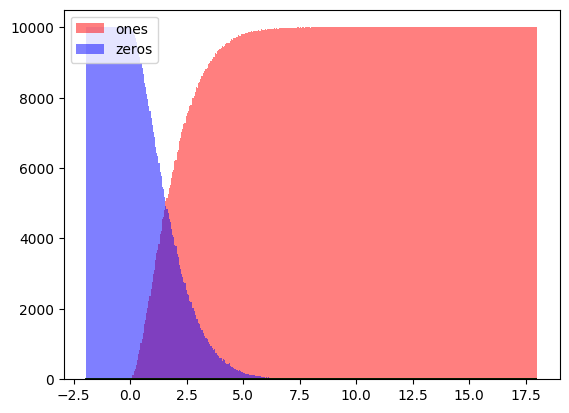

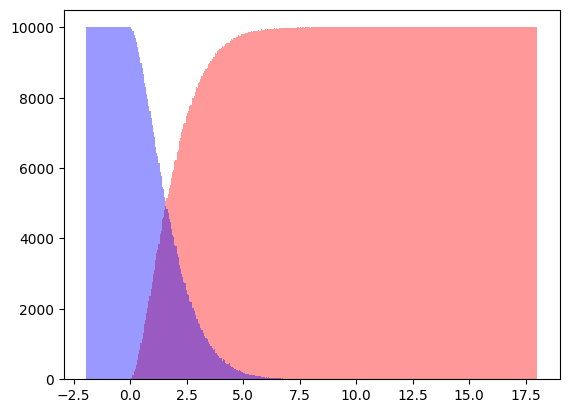

In [3]:
mu = -2
sigma = 2
k = 1.5
x = np.arange(mu+0.05, mu+10*sigma, 0.05);
F = 1-np.exp(-np.power((-(mu-x)/sigma), k));
num_repetitions = 10000
xx = np.array([x]*num_repetitions);
xx = xx.reshape(1, num_repetitions*len(x))[0];

u1 = np.random.rand(len(xx));#
# u2 = np.random.rand(len(x))
F_inverse_u = xx - sigma*np.power((-np.log(1-u1)), 1/k);#

print(F_inverse_u.shape);
# F_inverse_u
x_ones = xx[F_inverse_u >= 0];
x_zeros = xx[F_inverse_u < 0];
n1, bins1,_ = plt.hist(x_ones, bins=np.append(x, x[-1] + 0.05), color='r', label= "ones", alpha=0.5, density=False);
n0, bins0,_ = plt.hist(x_zeros, bins=np.append(x, x[-1] + 0.05), color='b', label= "zeros", alpha=0.5, density=False);
empirical_probs = list(map(lambda tup : tup[0]/(tup[0]+tup[1]), zip(n1,n0) ))

F_0 = 1-np.exp(-np.power((-(-x)/sigma), k));
plt.plot(x, F_0, color='y');
plt.plot(x, empirical_probs, color='g');
F_sig = 1/(1+np.exp(-x/(0.5*sigma)))
plt.plot(x, F_sig, color='k');
plt.legend();
# plt.plot(x, F)


# n1, bins1,_ = plt.hist(x_ones, bins=np.append(x, x[-1] + 0.05), color='r', label= "ones", alpha=0.5, density=True);


def generate_x_y_gev(n0, n1, bins):
    X = np.array([])
    y = np.array([])
    binsize = bins[-1]-bins[-2]
    for tupp in zip(n0, n1, bins ):
#         print(tupp)
        x_zeros = tupp[2] + binsize*np.random.rand(int(tupp[0]))
        x_ones = tupp[2] + binsize*np.random.rand(int(tupp[1]))
        X = np.concatenate([X, x_zeros, x_ones])
        y = np.concatenate([y, np.zeros(len(x_zeros)), np.ones(len(x_ones)) ])
#         set_trace()
    return X,y

X,y = generate_x_y_gev(n0, n1, bins1);
plt.figure()
X_ones = X[y==1]
X_zeros = X[y==0]
plt.hist(X_ones, bins=bins1, color = 'r', alpha = 0.4)
plt.hist(X_zeros, bins=bins1, color = 'b', alpha = 0.4)
plt.show();

In [ ]:
a = np.array([1])
b = np.array([2])
c = [3]
d = np.concatenate([a,b,c])
np.random.rand(3)

In [ ]:
rn = np.random.rand(2,3)
x = np.array([1,2]*3)
# tmp = x + np.exp(rn)
rn
x
np.exp(rn)

In [ ]:
np.append([np.array([]), np.arange(1,10)])